In [1]:
from __future__ import print_function

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google.oauth2.credentials import Credentials
from azure.storage.blob import BlobServiceClient

import pandas as pd
import os.path
import json
pd.set_option('display.max_rows', 500)

In [2]:
SCOPES = ['https://www.googleapis.com/auth/drive.readonly']
root_dir =  os.path.abspath(os.getcwd()+"..\\..\\..\\..\\")
tmp_dir = root_dir + "\\.tmp"
cred_dir = root_dir + "\\.cred"
data_dir = root_dir + "\\data\\"
site_summary_filename = data_dir + "hourly-site-summary.csv"

# Upload full halft hourly data from Google Drive to Azure Storage Blob

In [3]:
creds = None
# The file token.json stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists(cred_dir+'\\token.json'):
    creds = Credentials.from_authorized_user_file(cred_dir+'\\token.json', SCOPES)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            cred_dir+'\\credentials.json', SCOPES)
        creds = flow.run_local_server(port=8001)
    # Save the credentials for the next run
    with open(cred_dir+'\\token.json', 'w') as token:
        token.write(creds.to_json())

In [4]:
uploadToAzBlob = False

if(uploadToAzBlob):
    connect_str = "DefaultEndpointsProtocol=https;AccountName=mids23spring;AccountKey=zVXGQElT0G0fsoMSqQz7Uztwc0GBAK60AICYC1o5AcKj0R5naF4vTGk+topPjfq3fxOoBfDpZbYw+AStPeF39w==;EndpointSuffix=core.windows.net"
    blob_service_client = BlobServiceClient.from_connection_string(connect_str)
    container_name = "full-half-hourly-raw"
    
    if not (os.path.exists(tmp_dir)):
        os.mkdir(tmp_dir)

In [54]:
# Build the Drive API client

file_df = pd.DataFrame(columns = ["filename", "size", "country", "site_id"])

targetFolderName = 'data_full_half_hourly'
queryPageSize = 512
queryFields = "nextPageToken, files(id, name, size)"

try:
    service = build('drive', 'v3', credentials=creds)
    queryFolder = f"mimeType='application/vnd.google-apps.folder' and name='{targetFolderName}'"
    results = service.files().list(q=queryFolder, pageSize=10, fields="nextPageToken, files(id, name)").execute()
    folders = results.get('files', [])

    if not folders:
        print('No folder found.')
    else:
        folder = folders[0]
        print(f'{folder["name"]}:')
        folder_id = folder["id"]
        query = f"'{folder_id}' in parents and trashed = false"
        results = service.files().list(q=query, pageSize=queryPageSize, fields=queryFields).execute()
        files = results.get('files', [])
        token = results.get('nextPageToken', None)
        
        fileCount = 0
        
        if files:
            for file in files:
                fileName = file["name"]
                fileId   = file["id"]
                fileSize = file["size"]
                station = fileName.split('_')[-1].split(".")[0]
                country = station.split('-')[0]

                print(f'{fileCount+1:3}. {fileName} ({fileSize:>10})')
                
                fileMetadata = {
                    "filename": fileName,
                    "size": fileSize,
                    "country": country,
                    "site_id": station
                }
                file_df=file_df.append(fileMetadata, ignore_index=True)
                fileCount += 1
                
                if(uploadToAzBlob):
                    # Download file from Google Drive to local .tmp drive
                    local_filename = tmp_dir + "\\" + fileName
                    if not (os.path.exists(local_filename)):
                        file_data = service.files().get(fileId=fileId, fields='*').execute()
                        request = service.files().get_media(fileId=fileId)
                        file_handle = request.execute()
                        with open(local_filename, "wb") as f:
                            f.write(file_handle)
                
                    # Create a blob client using the local file name as the name for the blob
                    blob_client = blob_service_client.get_blob_client(container=container_name, blob=fileName)
                    with open(local_filename, "rb") as data:
                        blob_client.upload_blob(data)
                    print(f'\t\'{fileName}\' uploaded.')
                    
            ## Get Next Page Content (still buggy)
            #results = service.files().list(q=query, pageToken=token, fields=queryFields).execute()
            #files = results.get('files', [])
            #token = results.get('nextPageToken', None)
            
except HttpError as error:
    print(F'An error occurred: {error}')
    print(F'{error.resp.status}, {error.resp.reason}')
    
file_df.dropna(inplace=True)

data_full_half_hourly:
  1. data_full_half_hourly_raw_v0_1_CN-HaM.csv (  21307369)
  2. data_full_half_hourly_raw_v0_1_US-UMd.csv (  70907532)
  3. data_full_half_hourly_raw_v0_1_AU-Emr.csv (  17707070)
  4. data_full_half_hourly_raw_v0_1_DE-Kli.csv ( 115031759)
  5. data_full_half_hourly_raw_v0_1_BE-Lcr.csv (  11988594)
  6. data_full_half_hourly_raw_v0_1_DK-Gds.csv (   2632580)
  7. data_full_half_hourly_raw_v0_1_CZ-RAJ.csv (  65198714)
  8. data_full_half_hourly_raw_v0_1_IT-Isp.csv (  13549264)
  9. data_full_half_hourly_raw_v0_1_CA-Gro.csv (  74132529)
 10. data_full_half_hourly_raw_v0_1_US-Sta.csv (  19848993)
 11. data_full_half_hourly_raw_v0_1_US-KS1.csv (   5279188)
 12. data_full_half_hourly_raw_v0_1_IL-Yat.csv ( 139597716)
 13. data_full_half_hourly_raw_v0_1_FR-LGt.csv (  25211279)
 14. data_full_half_hourly_raw_v0_1_DK-Fou.csv (   4758374)
 15. data_full_half_hourly_raw_v0_1_IE-Cra.csv (   6989126)
 16. data_full_half_hourly_raw_v0_1_SE-Lnn.csv (  32921480)
 17. data_full_ha

140. data_full_half_hourly_raw_v0_1_DE-Gri.csv ( 120679560)
141. data_full_half_hourly_raw_v0_1_US-Ro5.csv (   7224928)
142. data_full_half_hourly_raw_v0_1_CA-Cbo.csv (  94426217)
143. data_full_half_hourly_raw_v0_1_US-IB2.csv (  53795158)
144. data_full_half_hourly_raw_v0_1_AU-Wom.csv (  36264406)
145. data_full_half_hourly_raw_v0_1_US-Wi1.csv (   2841430)
146. data_full_half_hourly_raw_v0_1_DE-Geb.csv ( 151108450)
147. data_full_half_hourly_raw_v0_1_US-Twt.csv (  40246042)
148. data_full_half_hourly_raw_v0_1_BR-Sa3.csv (  22957962)
149. data_full_half_hourly_raw_v0_1_SD-Dem.csv (  17224643)
150. data_full_half_hourly_raw_v0_1_CA-WP3.csv (   7206117)
151. data_full_half_hourly_raw_v0_1_ES-Amo.csv (  35999834)
152. data_full_half_hourly_raw_v0_1_US-OWC.csv (   4547681)
153. data_full_half_hourly_raw_v0_1_DE-Hte.csv (  59752741)
154. data_full_half_hourly_raw_v0_1_US-Dk1.csv (  49402459)
155. data_full_half_hourly_raw_v0_1_CA-WP2.csv (   9330219)
156. data_full_half_hourly_raw_v0_1_US-T

In [55]:
file_df.sort_values("filename")

,filename,size,country,site_id
32,data_full_half_hourly_raw_v0_1_AR-SLu.csv,9785735,AR,AR-SLu
221,data_full_half_hourly_raw_v0_1_AR-Vir.csv,14564015,AR,AR-Vir
28,data_full_half_hourly_raw_v0_1_AT-Neu.csv,80674656,AT,AT-Neu
124,data_full_half_hourly_raw_v0_1_AU-ASM.csv,32588027,AU,AU-ASM
130,data_full_half_hourly_raw_v0_1_AU-Ade.csv,10951700,AU,AU-Ade
169,data_full_half_hourly_raw_v0_1_AU-Cpr.csv,31569504,AU,AU-Cpr
228,data_full_half_hourly_raw_v0_1_AU-Cum.csv,16483369,AU,AU-Cum
86,data_full_half_hourly_raw_v0_1_AU-DaP.csv,39509404,AU,AU-DaP
64,data_full_half_hourly_raw_v0_1_AU-DaS.csv,49712116,AU,AU-DaS
218,data_full_half_hourly_raw_v0_1_AU-Dry.csv,34886065,AU,AU-Dry


In [56]:
file_df.shape

(276, 4)

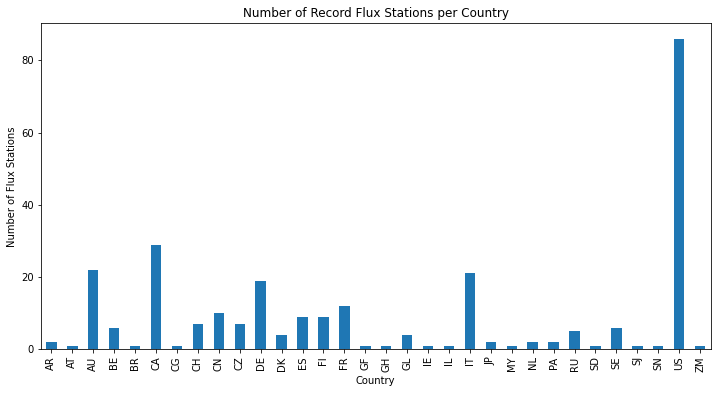

In [57]:
plot = file_df.groupby('country')['filename'].count()\
        .plot(kind='bar', figsize = (12,6),
              title = 'Number of Record Flux Stations per Country',
              xlabel = "Country",
              ylabel = "Number of Flux Stations")

In [58]:
# Save site_data checkpoint
file_df.to_csv(site_summary_filename, index_label="index");

# Sample Site Data EDA

In [9]:
# process sample file
local_filename = tmp_dir + "\\" + 'data_full_half_hourly_raw_v0_1_AU-How.csv'
df = pd.read_csv(local_filename)
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])
print(f"size:{df.shape}")
print(f"columns: {df.columns}")
df.head()

size:(196752, 64)
columns: Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'TA_F', 'TA_F_QC', 'TA_ERA',
       'SW_IN_POT', 'SW_IN_F', 'SW_IN_F_QC', 'SW_IN_ERA', 'LW_IN_F',
       'LW_IN_F_QC', 'LW_IN_ERA', 'VPD_F', 'VPD_F_QC', 'VPD_ERA', 'P_F',
       'P_F_QC', 'P_ERA', 'PA_F', 'PA_F_QC', 'PA_ERA', 'NETRAD', 'PPFD_IN',
       'G_F_MDS', 'G_F_MDS_QC', 'LE_F_MDS', 'LE_F_MDS_QC', 'LE_CORR',
       'H_F_MDS', 'H_F_MDS_QC', 'H_CORR', 'NEE_VUT_REF', 'NEE_VUT_REF_QC',
       'NEE_CUT_REF', 'NEE_CUT_REF_QC', 'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF',
       'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF', 'RECO_NT_VUT_REF',
       'RECO_DT_VUT_REF', 'RECO_NT_CUT_REF', 'RECO_DT_CUT_REF', 'datetime',
       'year', 'month', 'day', 'hour', 'SITE_ID', 'date', 'NEE_VUT_REF_qa',
       'SW_DIF', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'koppen'],
      dtype='object')


,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
0,200109070000,200109070030,24.603,1,24.505,0.0,0.0,0,0.0,371.706,...,0.067572,0.0879,0.1872,0.043,0.0666,NaN,0.247,0.1898,WSA,Tropical
1,200109070030,200109070100,24.610,1,24.091,0.0,0.0,0,0.0,369.838,...,0.067572,0.0879,0.1872,0.043,0.0666,NaN,0.247,0.1898,WSA,Tropical
2,200109070100,200109070130,24.619,1,23.886,0.0,0.0,0,0.0,369.838,...,0.067572,0.0879,0.1872,0.043,0.0666,NaN,0.247,0.1898,WSA,Tropical
3,200109070130,200109070200,24.625,1,23.682,0.0,0.0,0,0.0,369.838,...,0.067572,0.0879,0.1872,0.043,0.0666,NaN,0.247,0.1898,WSA,Tropical
4,200109070200,200109070230,24.627,1,23.477,0.0,0.0,0,0.0,369.838,...,0.067572,0.0879,0.1872,0.043,0.0666,NaN,0.247,0.1898,WSA,Tropical


In [11]:
df.tail()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
196747,201412312130,201412312200,23.73,0,25.108,0.0,0.0,0,0.0,399.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WSA,Tropical
196748,201412312200,201412312230,23.58,0,25.121,0.0,0.0,0,0.0,400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WSA,Tropical
196749,201412312230,201412312300,23.23,0,25.135,0.0,0.0,0,0.0,396.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WSA,Tropical
196750,201412312300,201412312330,23.38,0,25.149,0.0,0.0,0,0.0,393.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WSA,Tropical
196751,201412312330,201501010000,23.39,0,25.163,0.0,0.0,0,0.0,396.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WSA,Tropical


In [12]:
df.isna().sum()

TIMESTAMP_START         0
TIMESTAMP_END           0
TA_F                    0
TA_F_QC                 0
TA_ERA                  0
SW_IN_POT               0
SW_IN_F                 0
SW_IN_F_QC              0
SW_IN_ERA               0
LW_IN_F                 0
LW_IN_F_QC              0
LW_IN_ERA               0
VPD_F                   0
VPD_F_QC                0
VPD_ERA                 0
P_F                     0
P_F_QC                  0
P_ERA                   0
PA_F                    0
PA_F_QC                 0
PA_ERA                  0
NETRAD              65309
PPFD_IN            196752
G_F_MDS             21646
G_F_MDS_QC          21646
LE_F_MDS                0
LE_F_MDS_QC             0
LE_CORR             14482
H_F_MDS                 0
H_F_MDS_QC              0
H_CORR              14482
NEE_VUT_REF             0
NEE_VUT_REF_QC          0
NEE_CUT_REF             0
NEE_CUT_REF_QC          0
GPP_NT_VUT_REF          0
GPP_DT_VUT_REF          0
GPP_NT_CUT_REF          0
GPP_DT_CUT_R

In [13]:
df.describe(include=['object'])

,SITE_ID,IGBP,koppen
count,196752,196752,196752
unique,1,1,1
top,AU-How,WSA,Tropical
freq,196752,196752,196752


In [14]:
df[['date', 'datetime']].describe(datetime_is_numeric=True)

,date,datetime
count,196752,196752
mean,2008-10-24 11:31:22.117589760,2008-10-24 23:16:22.117590528
min,2001-09-07 00:00:00,2001-09-07 00:00:00
25%,2005-04-06 00:00:00,2005-04-06 17:52:30
50%,2009-02-24 00:00:00,2009-02-24 11:45:00
75%,2012-03-12 00:00:00,2012-03-12 05:37:30
max,2014-12-31 00:00:00,2014-12-31 23:30:00


In [15]:
df['date'].unique().shape[0]

4099

## Other Numerical Describes

In [38]:
df[['TA_F', 'TA_F_QC', 'TA_ERA',
    'SW_IN_POT', 'SW_IN_F', 'SW_IN_F_QC', 'SW_IN_ERA', 'SW_DIF',
    'LW_IN_F','LW_IN_F_QC', 'LW_IN_ERA',
    'VPD_F', 'VPD_F_QC', 'VPD_ERA',
    'P_F', 'P_F_QC', 'P_ERA',
    'PA_F', 'PA_F_QC', 'PA_ERA',]].describe()

,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,LW_IN_F_QC,LW_IN_ERA,VPD_F,VPD_F_QC,VPD_ERA,P_F,P_F_QC,P_ERA,PA_F,PA_F_QC,PA_ERA
count,178464.000000,178464.000000,178464.000000,178464.000000,178464.000000,178464.000000,178464.000000,178464.000000,178464.0,178464.000000,178464.000000,178464.0,178464.000000,178464.000000,178464.0,178464.000000,178464.000000,178464.000000,178464.000000
mean,7.534998,0.022716,7.547930,310.171940,154.701584,0.099779,155.567193,306.769507,2.0,306.769507,3.095862,2.0,3.095862,0.041919,2.0,0.041919,98.214514,0.043785,98.214613
std,10.927897,0.191460,10.721873,392.792843,245.048833,0.429272,228.244272,49.737927,0.0,49.737927,2.909570,0.0,2.909570,0.148174,0.0,0.148174,0.763945,0.292665,0.756565
min,-24.931000,0.000000,-25.892000,0.000000,0.000000,0.000000,0.000000,171.170000,2.0,171.170000,0.000000,2.0,0.000000,0.000000,2.0,0.000000,94.464000,0.000000,94.279000
25%,-0.823000,0.000000,-0.693250,0.000000,0.000000,0.000000,0.000000,269.312000,2.0,269.312000,0.867000,2.0,0.867000,0.000000,2.0,0.000000,97.752000,0.000000,97.758000
50%,8.150500,0.000000,8.066000,22.258000,4.987500,0.000000,1.786000,308.368000,2.0,308.368000,2.082000,2.0,2.082000,0.000000,2.0,0.000000,98.258000,0.000000,98.252000
75%,16.620000,0.000000,16.735000,599.107000,223.314500,0.000000,264.520500,344.965000,2.0,344.965000,4.489000,2.0,4.489000,0.021000,2.0,0.021000,98.714000,0.000000,98.704000
max,33.363000,2.000000,30.242000,1232.630000,1090.600000,2.000000,887.242000,430.248000,2.0,430.248000,18.323000,2.0,18.323000,9.153000,2.0,9.153000,101.730000,2.000000,100.762000


In [39]:
df[['NETRAD', 'PPFD_IN',
    'G_F_MDS', 'G_F_MDS_QC', 'LE_F_MDS', 'LE_F_MDS_QC',
    'LE_CORR', 'H_F_MDS', 'H_F_MDS_QC', 'H_CORR']].describe()

,NETRAD,PPFD_IN,G_F_MDS,G_F_MDS_QC,LE_F_MDS,LE_F_MDS_QC,LE_CORR,H_F_MDS,H_F_MDS_QC,H_CORR
count,169066.000000,170619.000000,0.0,0.0,178464.000000,0.0,0.0,178464.000000,0.0,0.0
mean,78.623883,315.065691,NaN,NaN,31.708562,NaN,NaN,32.532709,NaN,NaN
std,193.871415,495.013612,NaN,NaN,69.953360,NaN,NaN,98.704773,NaN,NaN
min,-172.420000,-0.139000,NaN,NaN,-217.609000,NaN,NaN,-266.034000,NaN,NaN
25%,-46.424500,0.018000,NaN,NaN,-0.400385,NaN,NaN,-22.830000,NaN,NaN
50%,-5.462000,21.158000,NaN,NaN,3.100000,NaN,NaN,-5.012000,NaN,NaN
75%,130.991750,451.259000,NaN,NaN,24.636500,NaN,NaN,50.052500,NaN,NaN
max,841.530000,2208.365000,NaN,NaN,970.410000,NaN,NaN,698.200000,NaN,NaN


In [40]:
df[['NEE_VUT_REF', 'NEE_VUT_REF_QC', 'NEE_VUT_REF_qa', 'NEE_CUT_REF', 'NEE_CUT_REF_QC',
    'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF', 'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF',
    'RECO_NT_VUT_REF', 'RECO_DT_VUT_REF', 'RECO_NT_CUT_REF', 'RECO_DT_CUT_REF']].describe()

,NEE_VUT_REF,NEE_VUT_REF_QC,NEE_VUT_REF_qa,NEE_CUT_REF,NEE_CUT_REF_QC,GPP_NT_VUT_REF,GPP_DT_VUT_REF,GPP_NT_CUT_REF,GPP_DT_CUT_REF,RECO_NT_VUT_REF,RECO_DT_VUT_REF,RECO_NT_CUT_REF,RECO_DT_CUT_REF
count,178464.000000,178464.000000,174787.000000,178464.000000,178464.000000,178464.000000,171264.000000,178464.000000,171264.000000,1.784640e+05,171264.000000,1.784640e+05,171264.000000
mean,-0.914380,0.501608,-0.918098,-0.912945,0.499905,3.653362,3.200591,3.648993,3.235395,2.738982e+00,2.756738,2.747093e+00,2.784879
std,6.344966,0.547142,6.340294,6.341733,0.544136,7.358862,6.512383,7.354752,6.596264,2.058157e+00,2.399876,2.062076e+00,2.421697
min,-43.172700,0.000000,-43.172700,-43.172700,0.000000,-28.807800,0.000000,-29.092400,0.000000,7.172870e-07,0.054456,6.887240e-07,0.054618
25%,-0.387922,0.000000,-0.373350,-0.386972,0.000000,-0.147320,0.000000,-0.148497,0.000000,8.271852e-01,0.793173,8.279783e-01,0.785655
50%,0.770161,0.000000,0.767600,0.769324,0.000000,0.298776,0.000000,0.296423,0.000000,2.226175e+00,1.878955,2.247565e+00,1.899520
75%,2.153215,1.000000,2.127260,2.151015,1.000000,2.839913,2.389460,2.844645,2.420280,4.507560e+00,4.198515,4.508930e+00,4.293495
max,33.497100,3.000000,33.497100,33.497100,3.000000,48.324700,35.961400,48.329600,36.195000,1.141180e+01,19.225300,1.153640e+01,19.829600


In [41]:
df[['EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']].describe()

,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7
count,133824.000000,133824.000000,133824.000000,133824.000000,133824.000000,133824.000000,133824.000000,133440.000000,125616.000000,133824.000000
mean,0.429998,0.674002,0.201514,0.056879,0.285677,0.043247,0.067580,0.267129,0.163010,0.068667
std,0.164103,0.227091,0.102278,0.053359,0.072639,0.056704,0.050372,0.056395,0.036758,0.028627
min,0.151701,0.128162,0.031508,0.015800,0.119200,0.009900,0.022500,0.128100,0.064200,0.026500
25%,0.253328,0.528532,0.096410,0.024800,0.222375,0.017200,0.042200,0.230400,0.145600,0.050100
50%,0.476000,0.772811,0.230202,0.034050,0.299800,0.020500,0.050000,0.277900,0.163200,0.056900
75%,0.587322,0.867359,0.298650,0.061700,0.348050,0.032200,0.060525,0.313500,0.180700,0.074800
max,0.680930,0.908886,0.356775,0.260200,0.411000,0.263800,0.257000,0.362000,0.250000,0.147100


# Get Site Metadata

In [3]:
# enable parallelism: https://stackoverflow.com/a/59385935
import asyncio

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

In [4]:
summary_df = pd.read_csv(site_summary_filename, index_col='index')
summary_df.head()

,filename,size,country,site_id
index,,,,
0,data_full_half_hourly_raw_v0_1_CN-HaM.csv,21307369,CN,CN-HaM
1,data_full_half_hourly_raw_v0_1_US-UMd.csv,70907532,US,US-UMd
2,data_full_half_hourly_raw_v0_1_AU-Emr.csv,17707070,AU,AU-Emr
3,data_full_half_hourly_raw_v0_1_DE-Kli.csv,115031759,DE,DE-Kli
4,data_full_half_hourly_raw_v0_1_BE-Lcr.csv,11988594,BE,BE-Lcr


In [5]:
# Add columns
summary_df['record_count'] = ''
summary_df['site_IGBP'] = ''
summary_df['site_koppen'] = ''
summary_df['start_time'] = ''
summary_df['end_time'] = ''
summary_df['recorded_date_count'] = ''

In [6]:
@background
def update_summary_record(index, r, summary_df):
    local_filename = tmp_dir + "\\" + r.filename
    site_df = pd.read_csv(local_filename)
    site_df['datetime'] = pd.to_datetime(site_df['datetime'])
    
    if(site_df.loc[0].SITE_ID != summary_df.loc[index].site_id):
          print(f'  ERROR: SiteID mismatch: {site_df.loc[0].SITE_ID} vs {summary_df.loc[index].site_id}.')
    
    summary_df.loc[index,'record_count'] = site_df.shape[0]
    summary_df.loc[index,'site_IGBP']    = site_df.loc[0].IGBP
    summary_df.loc[index,'site_koppen']  = site_df.loc[0].koppen
    summary_df.loc[index,'start_time']   = site_df['datetime'].min()
    summary_df.loc[index,'end_time']     = site_df['datetime'].max()
    summary_df.loc[index,'recorded_date_count'] = site_df['date'].unique().shape[0]
    print(f'{index:3}. Got {site_df.loc[0].SITE_ID} info from {r.filename}.')

In [ ]:
import nest_asyncio
nest_asyncio.apply()
loop = asyncio.get_event_loop()
looper = asyncio.gather(*[update_summary_record(index, r, summary_df) for index, r in summary_df.iterrows()])         # Run the loop                
results = loop.run_until_complete(looper)
print(f'Site summary update completed.')

  5. Got DK-Gds info from data_full_half_hourly_raw_v0_1_DK-Gds.csv.
  4. Got BE-Lcr info from data_full_half_hourly_raw_v0_1_BE-Lcr.csv.
  7. Got IT-Isp info from data_full_half_hourly_raw_v0_1_IT-Isp.csv.
  2. Got AU-Emr info from data_full_half_hourly_raw_v0_1_AU-Emr.csv.
  0. Got CN-HaM info from data_full_half_hourly_raw_v0_1_CN-HaM.csv.
 10. Got US-KS1 info from data_full_half_hourly_raw_v0_1_US-KS1.csv.
 13. Got DK-Fou info from data_full_half_hourly_raw_v0_1_DK-Fou.csv.
  9. Got US-Sta info from data_full_half_hourly_raw_v0_1_US-Sta.csv.
 14. Got IE-Cra info from data_full_half_hourly_raw_v0_1_IE-Cra.csv.
 12. Got FR-LGt info from data_full_half_hourly_raw_v0_1_FR-LGt.csv.
 15. Got SE-Lnn info from data_full_half_hourly_raw_v0_1_SE-Lnn.csv.
  6. Got CZ-RAJ info from data_full_half_hourly_raw_v0_1_CZ-RAJ.csv.
  1. Got US-UMd info from data_full_half_hourly_raw_v0_1_US-UMd.csv.
 19. Got ES-Ln2 info from data_full_half_hourly_raw_v0_1_ES-Ln2.csv.
  8. Got CA-Gro info from data_ful

120. Got US-Goo info from data_full_half_hourly_raw_v0_1_US-Goo.csv.
126. Got CN-Ha2 info from data_full_half_hourly_raw_v0_1_CN-Ha2.csv.
105. Got DE-Tha info from data_full_half_hourly_raw_v0_1_DE-Tha.csv.
124. Got AU-ASM info from data_full_half_hourly_raw_v0_1_AU-ASM.csv.
111. Got SE-Deg info from data_full_half_hourly_raw_v0_1_SE-Deg.csv.
130. Got AU-Ade info from data_full_half_hourly_raw_v0_1_AU-Ade.csv.
123. Got US-Vcp info from data_full_half_hourly_raw_v0_1_US-Vcp.csv.
118. Got IT-Tor info from data_full_half_hourly_raw_v0_1_IT-Tor.csv.
125. Got US-Dk3 info from data_full_half_hourly_raw_v0_1_US-Dk3.csv.
127. Got CA-WP1 info from data_full_half_hourly_raw_v0_1_CA-WP1.csv.
128. Got US-FR2 info from data_full_half_hourly_raw_v0_1_US-FR2.csv.
135. Got AU-Lox info from data_full_half_hourly_raw_v0_1_AU-Lox.csv.
134. Got US-Wi3 info from data_full_half_hourly_raw_v0_1_US-Wi3.csv.
133. Got US-Pnp info from data_full_half_hourly_raw_v0_1_US-Pnp.csv.
140. Got US-Ro5 info from data_ful

242. Got JP-MBF info from data_full_half_hourly_raw_v0_1_JP-MBF.csv.
245. Got US-ARb info from data_full_half_hourly_raw_v0_1_US-ARb.csv.
231. Got BE-Lon info from data_full_half_hourly_raw_v0_1_BE-Lon.csv.
238. Got FR-Hes info from data_full_half_hourly_raw_v0_1_FR-Hes.csv.
243. Got MY-PSO info from data_full_half_hourly_raw_v0_1_MY-PSO.csv.
246. Got US-Fmf info from data_full_half_hourly_raw_v0_1_US-Fmf.csv.
244. Got CH-Oe1 info from data_full_half_hourly_raw_v0_1_CH-Oe1.csv.
237. Got BE-Dor info from data_full_half_hourly_raw_v0_1_BE-Dor.csv.
250. Got CA-Qc2 info from data_full_half_hourly_raw_v0_1_CA-Qc2.csv.
241. Got IT-Noe info from data_full_half_hourly_raw_v0_1_IT-Noe.csv.
249. Got FI-Lom info from data_full_half_hourly_raw_v0_1_FI-Lom.csv.
256. Got ZM-Mon info from data_full_half_hourly_raw_v0_1_ZM-Mon.csv.
255. Got US-Me4 info from data_full_half_hourly_raw_v0_1_US-Me4.csv.
247. Got CA-TP3 info from data_full_half_hourly_raw_v0_1_CA-TP3.csv.
254. Got FI-Jok info from data_ful

In [ ]:
summary_df.tail()

In [ ]:
summary_df.isna().sum()

In [ ]:
# Save site_data checkpoint
summary_df.to_csv(site_summary_filename, index_label="index");